# Predict C-to-U editing sites from a fasta file

## Environment

In [1]:
import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt

## Deepred-Mt installation

In [2]:
!pip install -U "deepredmt @ git+https://github.com/aedera/deepredmt.git" > /dev/null

  Running command git clone -q https://github.com/aedera/deepredmt.git /tmp/pip-install-wuqs3v28/deepredmt


## Make predictions

We will make predictions using a fasta file containing the sequences of the mitochondrial protein-coding genes of a flowering plant called *Lophophytum mirabile*.

In [3]:
!wget https://raw.githubusercontent.com/aedera/deepredmt/main/fasta/lopho.fas

--2021-04-22 12:26:41--  https://raw.githubusercontent.com/aedera/deepredmt/main/fasta/lopho.fas
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32597 (32K) [text/plain]
Saving to: ‘lopho.fas’

lopho.fas           100%[===================>]  31.83K  --.-KB/s    in 0.002s  

2021-04-22 12:26:41 (17.2 MB/s) - ‘lopho.fas’ saved [32597/32597]



Now, we can call Deepred-Mt passing as argument the downloaded fasta file `lopho.fas`.

In [4]:
!deepredmt lopho.fas > lopho.pred

The above command stores the output of Deepred-Mt in a file named `lopho.pred`. We can inspect the format of this output file by taking ten random predictions.

In [5]:
!shuf lopho.pred | head -10 | column -t

nad4!890           AATATATACTTCCTEGACEA  C  TTEAAGACAGATCGATCTTA  0.000
rpl2!214           ATCGTTCTTCTCGGATCGCT  C  EAGTACGATGGGGACTAGGC  0.001
cob!984            TCAAGTTTTCGCCCTATTEA  C  CAAGGAATATTTTGGTTACT  0.001
ccmfn!1287         GGCTGGTGGTTTEGGGATCC  C  GTAGAAAATGCTTCTTTTAT  0.005
cob!975            GTGCGTAGTTCAAGTTTTCG  C  CCTATTEACCAAGGAATATT  0.002
nad1!544           AGCAGATATGGTEEGGTATT  C  CCTTGTTCCCTGTATTGGTT  0.000
KU992338_rps4!229  AGATGCACAGAGGAAGAGAA  C  GAACTTCATATATCCCTTTT  0.000
nad7!917           GAAACTATCCATGGAATCCT  E  AATTCACCATTTTGAACTTT  0.999
cox1!1538          AAGTCCTCCAGCTTTTCATA  C  TTTTGGAGAACTGCCAGCTA  0.000
rps14!202          ACCGATGTATTTCCACGGGT  C  GCCCTEGTTCCGTATATGAG  0.009


The output file has five columns:


1.   Sequence name and position: this value of this column contains two fields delimited by '!': the first field is the name of the sequence, as appeared in the fasta file, whereas the second field is the sequence target position used for the prediction.

The following three columns shows the nucleotides extracted around the target position to make predictions:

2.   Upstream nucleotides: 20 base pairs upstream of the target position.
3.   Nucleotide in the target position: Deepred-Mt scans for positions containing cytidines represented by either 'C' or 'E', as explained below.
4.   Downstream nucleotides: 20 base pairs downstream of the target position.

Finally,

5.   Prediction score: a number between $[0, 1]$ scoring if the center position is an editing site.


## Analyze predictive performance

To evaluate the predictive performance of Deepred-Mt, we can use the C-to-U editing sites previously identified with [deep RNA sequencing](https://doi.org/10.1111/nph.16926) for the mitochondrial protein-coding gene sequences of *Lophophytum mirabile*. These identified sites were already annotated in the downloaded fasta file `lopho.pred` as a fifth nucleotide 'E'. Since Deepred-Mt treats such nucleotides as cytidines, we can compare the predictions with these identifications.
 

For this comparision analysis, the following command takes the central positions and their corresponding scores, replacing central positions for zero or one when they are 'C' or 'E', respectively.

In [6]:
!cut -f3,5 lopho.pred | sed 's/C/0/g' | sed 's/E/1/g' > lopho.parsed_pred
!head -10 lopho.parsed_pred

1	0.003
0	0.024
0	0.005
0	0.000
0	0.014
0	0.000
0	0.000
0	0.000
0	0.000
0	0.000


To measure the predictive performance, precision and recall are standard metrics often used when the classes are imbalanced.

Precision is defined as the number of true positives (tp) over the number of true positives plus the number of false positives (fp):

$\text{pr}=\frac{tp}{tp+fp}$

Recall is defined as the number of true positives over the number of true positives plus the number of false negatives (fn):

$\text{re}=\frac{tp}{tp+fn}$

To combine both metrics in a single value, the harmonic mean or $F_1$ score of precision and recall is often used:

$F_1=2\frac{\text{pr} \cdot \text{re}}{\text{pr} + \text{re}}$

The following python code calculates the precision-recall of Deepred-Mt for different thresholds, used to define scores as positive predictions. 

In [7]:
def performance(y_true, y_pred):                                                                                                                                                   
    """Calculate recall, precision, and F1."""
    pr = sklearn.metrics.precision_score(y_true, y_pred)
    re = sklearn.metrics.recall_score(y_true, y_pred)
    F1 = sklearn.metrics.f1_score(y_true, y_pred)

    return pr, re, F1 

In [8]:
# This command reads the parsed prediction file
preds = np.loadtxt('lopho.parsed_pred')
y_true, y_pred = preds[:,0], preds[:,1] # identification and predictions

print(y_true[0:10], y_pred[0:10])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.003 0.024 0.005 0.    0.014 0.    0.    0.    0.    0.   ]


In [9]:
# calculate metrics for different thresholds
scores = [performance(y_true, y_pred >= t) for t in np.arange(0, 1.01, .01)]
scores = np.asarray(scores)

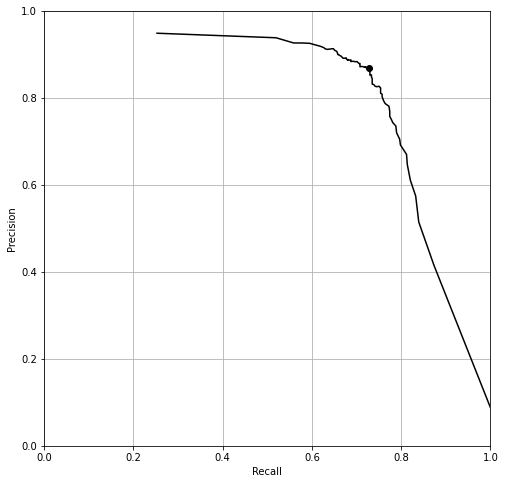

In [10]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(scores[:,1], scores[:,0], c='black')

# show f1max
nrow = np.argmax(scores[:,2])
plt.plot(scores[nrow,1], scores[nrow,0], 'ro', c='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.grid(True)

plt.show()